# Apprentissage Automatique Quantique pour la Prédiction de Maladies Cardiaques 

Notebook étendu incluant une section d'hyperparameter tuning automatique via **Optuna**,
ainsi qu'une comparaison des performances entre le modèle quantique et les modèles classiques.

# Cleveland Heart Disease Dataset

### Objectifs

Le but de ce jeu de données est de prédire la présence de maladies cardiaques chez un patient. La variable cible, num, est un entier variant de 0 à 4, où :

0 : Absence de maladie cardiaque

1–4 : Présence de maladie cardiaque (avec des degrés de sévérité croissants)

Les valeurs 1 à 4 sont souvent regroupées pour une classification binaire : présence (1) ou absence (0) de maladie cardiaque.

### Attributs

Le jeu de données comprend 14 attributs cliniques et démographiques :

age : Âge du patient (en années)

sex : Sexe du patient (1 = homme, 0 = femme)

cp : Type de douleur thoracique (1 à 4)

trestbps : Pression artérielle au repos (en mm Hg)

chol : Taux de cholestérol sérique (en mg/dl)

fbs : Glycémie à jeun > 120 mg/dl (1 = vrai, 0 = faux)

restecg : Résultats de l'ECG au repos (0 à 2)

thalach : Fréquence cardiaque maximale atteinte

exang : Angine induite par l'exercice (1 = oui, 0 = non)

oldpeak : Dépression du segment ST induite par l'exercice par rapport au repos

slope : Pente du segment ST lors de l'exercice maximal (1 à 3)

ca : Nombre de vaisseaux majeurs (0 à 3) colorés par fluoroscopie

thal : Thallium (3 = normal, 6 = défaut fixe, 7 = défaut réversible)

num : Présence de maladie cardiaque (0 à 4)

## Installer les dépendances
```bash
pip install pandas numpy scikit-learn matplotlib seaborn optuna xgboost joblib pennylane torch
```

In [1]:
# Imports de base
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost as xgb
import json
import pennylane as qml
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA 

import warnings
warnings.filterwarnings('ignore')

c:\Users\smcco\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Chargement et nettoyage

In [2]:
# --- Load dataset---

uci_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

try:
    df = pd.read_csv(uci_url, header=None)
    print("Data loaded successfully.")
except Exception as e:
    print("Error loading data:", e)
    exit(1)

print('Data shape:', df.shape)

Data loaded successfully.
Data shape: (303, 14)


In [3]:
df.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','target']
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [4]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


In [5]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


In [7]:
df.replace('?', pd.NA, inplace=True)
for col in ['ca','thal']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['ca'] = df['ca'].fillna(df['ca'].median())
df['thal'] = df['thal'].fillna(df['thal'].mode()[0])
df['target'] = df['target'].apply(lambda x: 1 if float(x) > 0 else 0)
cat_cols = ['sex','cp','fbs','restecg','exang','slope','thal','ca']
for c in cat_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce').astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    float64
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(5), int64(9)
memory usage: 33.3 KB


## Préprocessing / Feature engineering

In [8]:
num_cols = ['age','trestbps','chol','thalach','oldpeak']
X = df.drop(columns=['target'])
y = df['target']
X['age_chol'] = X['age'] * X['chol']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
scaler = StandardScaler()

X_train[num_cols+['age_chol']] = scaler.fit_transform(X_train[num_cols+['age_chol']])
X_test[num_cols+['age_chol']] = scaler.transform(X_test[num_cols+['age_chol']])
X_train_num = X_train.select_dtypes(include=[int,float]).values
X_test_num = X_test.select_dtypes(include=[int,float]).values

print('Prepared numeric arrays for modeling')

Prepared numeric arrays for modeling


## Optuna: Hyperparameter tuning (classical models)

In [10]:
studies = {}
n_trials = 50

In [11]:
def objective_lr(trial, X, y):
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    clf = LogisticRegression(C=C, penalty='l2', solver='lbfgs', max_iter=1000)
    scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
    return float(np.mean(scores))


print('Starting Optuna tuning for Logistic Regression...')
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(lambda t: objective_lr(t, X_train_num, y_train.values), n_trials=n_trials)
studies['LogisticRegression'] = study_lr
print('Best LR AUC:', study_lr.best_value)

[I 2025-10-07 04:17:15,612] A new study created in memory with name: no-name-bd57e80c-b9ec-4881-9b92-88dea4956119
[I 2025-10-07 04:17:15,662] Trial 0 finished with value: 0.8875910723736811 and parameters: {'C': 6.56476083072879}. Best is trial 0 with value: 0.8875910723736811.


Starting Optuna tuning for Logistic Regression...


[I 2025-10-07 04:17:15,712] Trial 1 finished with value: 0.8879407227233314 and parameters: {'C': 8.981708110876857}. Best is trial 1 with value: 0.8879407227233314.
[I 2025-10-07 04:17:15,762] Trial 2 finished with value: 0.8868788216614304 and parameters: {'C': 32.440382777048775}. Best is trial 1 with value: 0.8879407227233314.
[I 2025-10-07 04:17:15,813] Trial 3 finished with value: 0.8858405684492642 and parameters: {'C': 99.04701927044033}. Best is trial 1 with value: 0.8879407227233314.
[I 2025-10-07 04:17:15,864] Trial 4 finished with value: 0.8858557706383794 and parameters: {'C': 67.73111496787229}. Best is trial 1 with value: 0.8879407227233314.
[I 2025-10-07 04:17:15,884] Trial 5 finished with value: 0.8770238618064704 and parameters: {'C': 0.0038835966424502094}. Best is trial 1 with value: 0.8879407227233314.
[I 2025-10-07 04:17:15,906] Trial 6 finished with value: 0.8753212166255645 and parameters: {'C': 0.00570529958070916}. Best is trial 1 with value: 0.887940722723331

Best LR AUC: 0.8903927795232143


In [12]:
def objective_rf(trial, X, y):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt','log2', None])
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, random_state=42)
    scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
    return float(np.mean(scores))


print('Starting Optuna tuning for Random Forest...')
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(lambda t: objective_rf(t, X_train_num, y_train.values), n_trials=n_trials)
studies['RandomForest'] = study_rf
print('Best RF AUC:', study_rf.best_value)

[I 2025-10-07 04:17:17,664] A new study created in memory with name: no-name-521aeded-767f-4964-a9c3-c7da3503f8a5


Starting Optuna tuning for Random Forest...


[I 2025-10-07 04:17:19,767] Trial 0 finished with value: 0.8875190027363941 and parameters: {'n_estimators': 441, 'max_depth': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8875190027363941.
[I 2025-10-07 04:17:20,699] Trial 1 finished with value: 0.8904580926320056 and parameters: {'n_estimators': 184, 'max_depth': 14, 'max_features': 'log2'}. Best is trial 1 with value: 0.8904580926320056.
[I 2025-10-07 04:17:21,278] Trial 2 finished with value: 0.8895217503913155 and parameters: {'n_estimators': 114, 'max_depth': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.8904580926320056.
[I 2025-10-07 04:17:22,552] Trial 3 finished with value: 0.8896045178653875 and parameters: {'n_estimators': 255, 'max_depth': 12, 'max_features': 'log2'}. Best is trial 1 with value: 0.8904580926320056.
[I 2025-10-07 04:17:24,779] Trial 4 finished with value: 0.8771229575577401 and parameters: {'n_estimators': 457, 'max_depth': 2, 'max_features': None}. Best is trial 1 with value: 0.890

Best RF AUC: 0.898208956904609


In [13]:
def objective_svc(trial, X, y):
    C = trial.suggest_loguniform('C', 1e-3, 1e2)
    gamma = trial.suggest_categorical('gamma', ['scale','auto'])
    kernel = trial.suggest_categorical('kernel', ['rbf','poly'])
    clf = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
    scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
    return float(np.mean(scores))


print('Starting Optuna tuning for SVM...')
study_svc = optuna.create_study(direction='maximize')
study_svc.optimize(lambda t: objective_svc(t, X_train_num, y_train.values), n_trials=n_trials)
studies['SVM'] = study_svc
print('Best SVM AUC:', study_svc.best_value)

[I 2025-10-07 04:18:07,922] A new study created in memory with name: no-name-4c42c9b2-0333-4f29-8291-2a92f80b72c6
[I 2025-10-07 04:18:07,950] Trial 0 finished with value: 0.8793402249923989 and parameters: {'C': 0.0032796575884702175, 'gamma': 'scale', 'kernel': 'poly'}. Best is trial 0 with value: 0.8793402249923989.
[I 2025-10-07 04:18:07,991] Trial 1 finished with value: 0.8463210702341136 and parameters: {'C': 15.578858365369403, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 0 with value: 0.8793402249923989.
[I 2025-10-07 04:18:08,016] Trial 2 finished with value: 0.878278323930498 and parameters: {'C': 0.020614549944075362, 'gamma': 'scale', 'kernel': 'poly'}. Best is trial 0 with value: 0.8793402249923989.
[I 2025-10-07 04:18:08,064] Trial 3 finished with value: 0.8258583606409694 and parameters: {'C': 33.617577037634184, 'gamma': 'scale', 'kernel': 'poly'}. Best is trial 0 with value: 0.8793402249923989.
[I 2025-10-07 04:18:08,104] Trial 4 finished with value: 0.8552402508924

Starting Optuna tuning for SVM...


[I 2025-10-07 04:18:08,141] Trial 5 finished with value: 0.8662145423014989 and parameters: {'C': 6.378017816127554, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 0 with value: 0.8793402249923989.
[I 2025-10-07 04:18:08,181] Trial 6 finished with value: 0.8783205522335958 and parameters: {'C': 0.007542232253547783, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 0 with value: 0.8793402249923989.
[I 2025-10-07 04:18:08,217] Trial 7 finished with value: 0.875242953503823 and parameters: {'C': 0.11928827297072953, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 0 with value: 0.8793402249923989.
[I 2025-10-07 04:18:08,241] Trial 8 finished with value: 0.8762389784128913 and parameters: {'C': 0.0011724509695559735, 'gamma': 'auto', 'kernel': 'poly'}. Best is trial 0 with value: 0.8793402249923989.
[I 2025-10-07 04:18:08,281] Trial 9 finished with value: 0.8779861040730607 and parameters: {'C': 0.037280558801129314, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 0 with value: 0.879340

Best SVM AUC: 0.8879153857414727


In [25]:
def objective_xgb(trial, X, y):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'eta': trial.suggest_loguniform('eta', 1e-3, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0)
    }
    clf = xgb.XGBClassifier(**param)
    scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
    return float(np.mean(scores))


print('Starting Optuna tuning for XGBoost...')
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(lambda t: objective_xgb(t, X_train_num, y_train.values), n_trials=n_trials)
studies['XGBoost'] = study_xgb
print('Best XGBoost AUC:', study_xgb.best_value)

[I 2025-10-07 04:19:06,473] A new study created in memory with name: no-name-342da012-9162-415a-af5c-45569ca97450
[I 2025-10-07 04:19:06,659] Trial 0 finished with value: 0.8890088172696868 and parameters: {'eta': 0.024100986059566173, 'max_depth': 8, 'subsample': 0.8853738246248659, 'colsample_bytree': 0.829632857319399}. Best is trial 0 with value: 0.8890088172696868.


Starting Optuna tuning for XGBoost...


[I 2025-10-07 04:19:06,807] Trial 1 finished with value: 0.8840833079963515 and parameters: {'eta': 0.0018231138062602742, 'max_depth': 8, 'subsample': 0.75790617506072, 'colsample_bytree': 0.5165123325594493}. Best is trial 0 with value: 0.8890088172696868.
[I 2025-10-07 04:19:06,966] Trial 2 finished with value: 0.8880178597569902 and parameters: {'eta': 0.029465538421297396, 'max_depth': 7, 'subsample': 0.9475428017610792, 'colsample_bytree': 0.7175974054167593}. Best is trial 0 with value: 0.8890088172696868.
[I 2025-10-07 04:19:07,096] Trial 3 finished with value: 0.880655495872887 and parameters: {'eta': 0.005836551031834377, 'max_depth': 9, 'subsample': 0.5393595601688115, 'colsample_bytree': 0.36512519831411755}. Best is trial 0 with value: 0.8890088172696868.
[I 2025-10-07 04:19:07,225] Trial 4 finished with value: 0.8814274292535161 and parameters: {'eta': 0.09850824072112142, 'max_depth': 10, 'subsample': 0.6177326075216099, 'colsample_bytree': 0.4745034682253695}. Best is t

Best XGBoost AUC: 0.8938515590689505


In [26]:
best_params = {k: v.best_params for k,v in studies.items()}
print("Best hyperparameters:", json.dumps(best_params, indent=2))

Best hyperparameters: {
  "LogisticRegression": {
    "C": 1.8368952372022858
  },
  "RandomForest": {
    "n_estimators": 124,
    "max_depth": 6,
    "max_features": "sqrt"
  },
  "SVM": {
    "C": 0.5704578440313239,
    "gamma": "scale",
    "kernel": "poly"
  },
  "XGBoost": {
    "eta": 0.0270512872330482,
    "max_depth": 7,
    "subsample": 0.818526162293938,
    "colsample_bytree": 0.7302728063242588
  }
}


## Entraînement des meilleurs modèles et sauvegarde des résultats

In [27]:
trained_models = {}
results_list = []

def train_and_eval_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(name, 'accuracy', acc, 'roc_auc', roc)
    results_list.append({'model':name,'accuracy':acc,'roc_auc':roc})
    trained_models[name] = model

lr_params = studies['LogisticRegression'].best_params
lr = LogisticRegression(C=lr_params['C'], penalty='l2', max_iter=1000)
train_and_eval_model('LogisticRegression', lr, X_train_num, y_train, X_test_num, y_test)

rf_params = studies['RandomForest'].best_params
rf = RandomForestClassifier(n_estimators=rf_params['n_estimators'], max_depth=rf_params['max_depth'], max_features=rf_params.get('max_features', None), random_state=42)
train_and_eval_model('RandomForest', rf, X_train_num, y_train, X_test_num, y_test)

svc_params = studies['SVM'].best_params
svc = SVC(C=svc_params['C'], kernel=svc_params['kernel'], gamma=svc_params['gamma'], probability=True)
train_and_eval_model('SVM', svc, X_train_num, y_train, X_test_num, y_test)


xgb_params = studies['XGBoost'].best_params
xgbc = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', **xgb_params)
train_and_eval_model('XGBoost', xgbc, X_train_num, y_train, X_test_num, y_test)


LogisticRegression accuracy 0.8688524590163934 roc_auc 0.9502164502164503
RandomForest accuracy 0.9180327868852459 roc_auc 0.9469696969696969
SVM accuracy 0.8360655737704918 roc_auc 0.9274891774891774
XGBoost accuracy 0.8852459016393442 roc_auc 0.9448051948051948


## Accuracy Comparaison

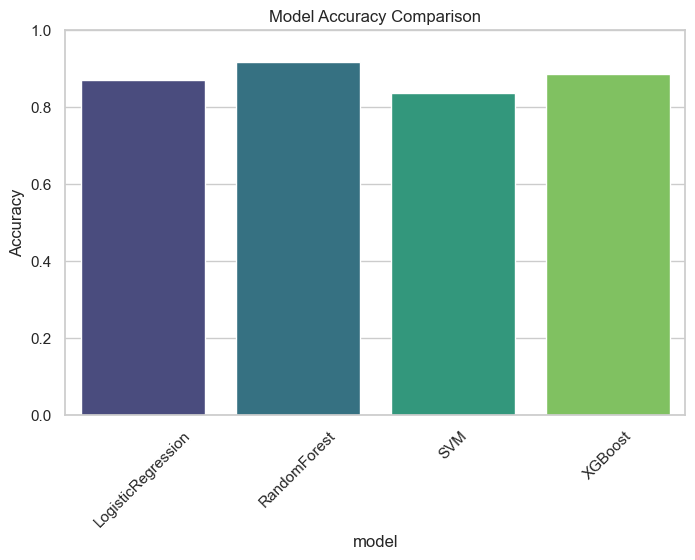

In [28]:
results_df = pd.DataFrame(results_list)

# Bar plot for accuracy
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='model', y='accuracy', palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

## Tracer ROC

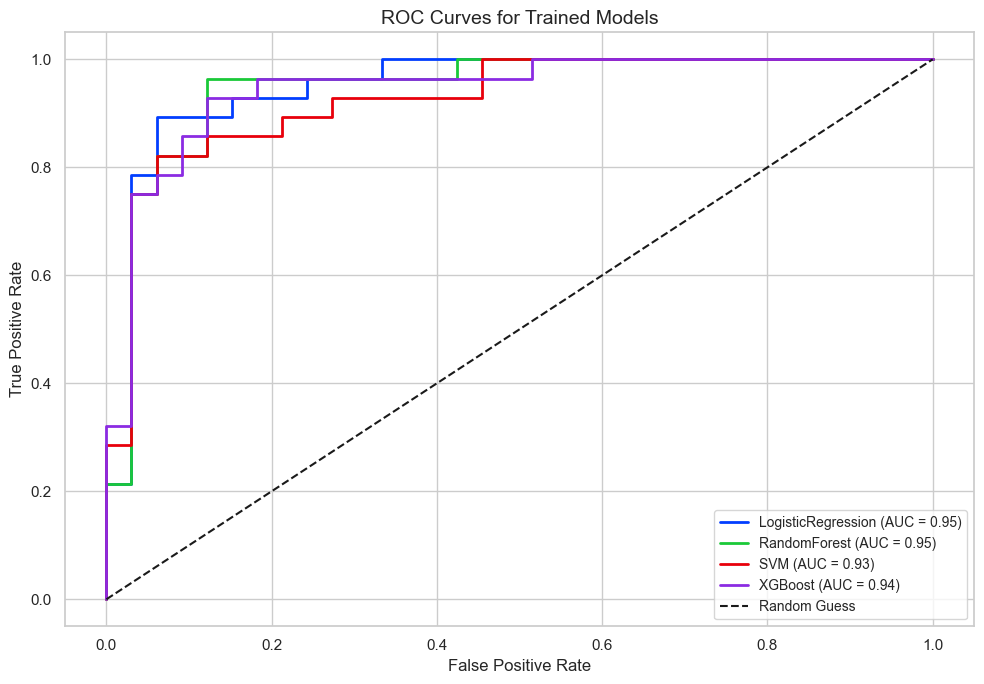

In [29]:
# Set a nice Seaborn style
sns.set(style="whitegrid")
palette = sns.color_palette("bright6", n_colors=len(trained_models))

plt.figure(figsize=(10, 7))

for i, (name, model) in enumerate(trained_models.items()):
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_num)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=palette[i], lw=2,
                 label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Guess')

# Labels and title
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Trained Models', fontsize=14)

# Legend outside the plot
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

## Tracer feature importances

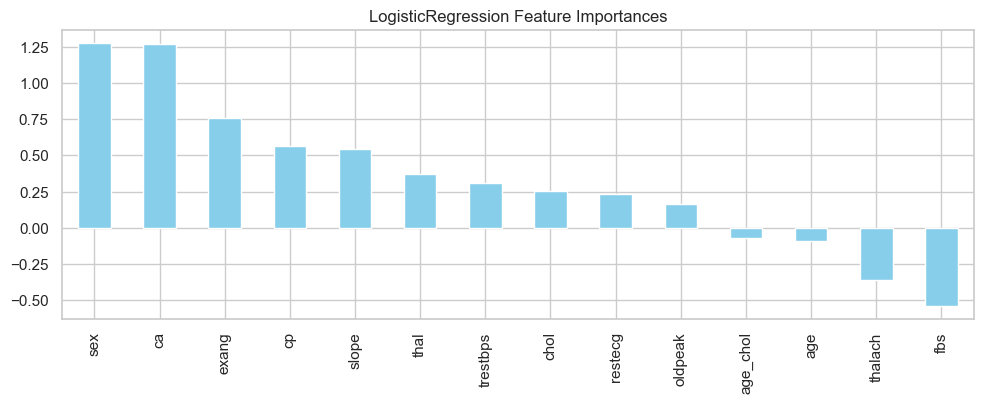

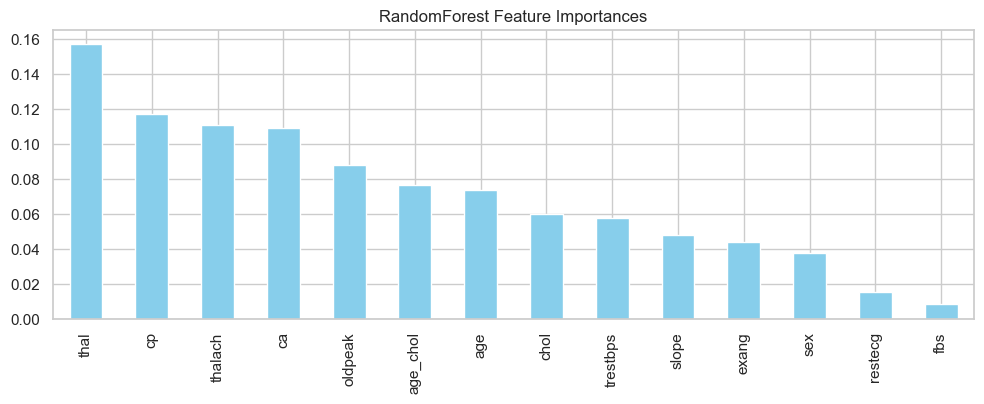

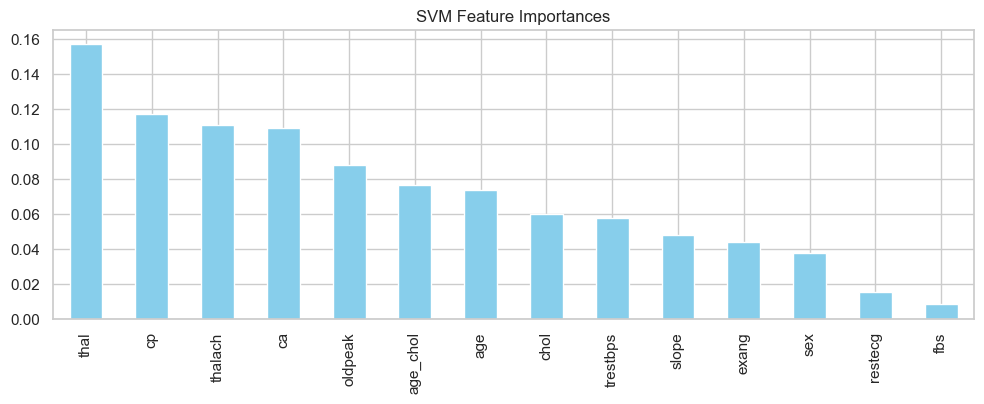

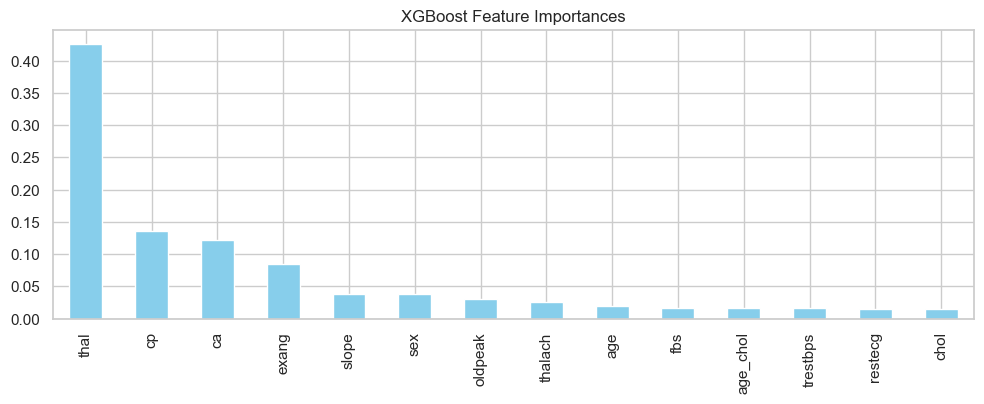

In [19]:
for name, model in trained_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = model.coef_.flatten()

    feat_names = X_train.select_dtypes(include=[int, float]).columns.tolist()
    fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)
    fi.plot(kind='bar', figsize=(10, 4), color='skyblue')
    plt.tight_layout()
    plt.title(f'{name} Feature Importances')
    plt.show()

## Quantum model

In [20]:
# Device: simulate with 4 qubits
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit (variational layer)
def circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

# QNode
n_layers = 2
weight_shapes = {"weights": (n_layers, n_qubits, 3)}
qnode = qml.QNode(circuit, dev, interface="torch")

# Wrap as Torch layer
class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

# Hybrid model: Quantum layer + classical output
class HybridModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, n_qubits)
        self.q = QuantumLayer()
        self.fc2 = nn.Linear(1, 2)  # binary classification

    def forward(self, x):
        x = torch.tanh(self.fc1(x))  # compress features
        x = self.q(x)
        x = x.unsqueeze(-1)  # ensure shape
        return self.fc2(x)

In [21]:
# ================================
# Data preparation for quantum model
# ================================

# Use fewer features (quantum circuits scale poorly) -> PCA or select subset
pca = PCA(n_components=n_qubits)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Convert to Torch tensors
X_train_t = torch.tensor(X_train_reduced, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)
X_test_t = torch.tensor(X_test_reduced, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=True)

In [22]:
# ================================
# Training
# ================================
model = HybridModel(n_features=n_qubits)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

n_epochs = 50
for epoch in range(n_epochs):
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss={total_loss:.4f}")

Epoch 1/50, Loss=10.2368
Epoch 2/50, Loss=8.6549
Epoch 3/50, Loss=7.4058
Epoch 4/50, Loss=7.0257
Epoch 5/50, Loss=6.7462
Epoch 6/50, Loss=7.4005
Epoch 7/50, Loss=6.6980
Epoch 8/50, Loss=6.6102
Epoch 9/50, Loss=6.5383
Epoch 10/50, Loss=6.5798
Epoch 11/50, Loss=6.4702
Epoch 12/50, Loss=6.4107
Epoch 13/50, Loss=6.5178
Epoch 14/50, Loss=6.4109
Epoch 15/50, Loss=6.8490
Epoch 16/50, Loss=6.3896
Epoch 17/50, Loss=6.5928
Epoch 18/50, Loss=6.3381
Epoch 19/50, Loss=6.5278
Epoch 20/50, Loss=6.2751
Epoch 21/50, Loss=6.1623
Epoch 22/50, Loss=6.2138
Epoch 23/50, Loss=6.1080
Epoch 24/50, Loss=6.1156
Epoch 25/50, Loss=6.2563
Epoch 26/50, Loss=6.7506
Epoch 27/50, Loss=6.1376
Epoch 28/50, Loss=6.5381
Epoch 29/50, Loss=6.5726
Epoch 30/50, Loss=6.1629
Epoch 31/50, Loss=6.3375
Epoch 32/50, Loss=7.2116
Epoch 33/50, Loss=6.4838
Epoch 34/50, Loss=6.3264
Epoch 35/50, Loss=6.9748
Epoch 36/50, Loss=6.8729
Epoch 37/50, Loss=7.6033
Epoch 38/50, Loss=6.1716
Epoch 39/50, Loss=7.5073
Epoch 40/50, Loss=6.1141
Epoch 41

In [23]:
# ================================
# Evaluation
# ================================
with torch.no_grad():
    preds = model(X_test_t).argmax(dim=1)
    acc = (preds == y_test_t).float().mean().item()
    print("Quantum-Classical Test Accuracy:", acc)

Quantum-Classical Test Accuracy: 0.8360655903816223


# Quantum model vs Classical Models

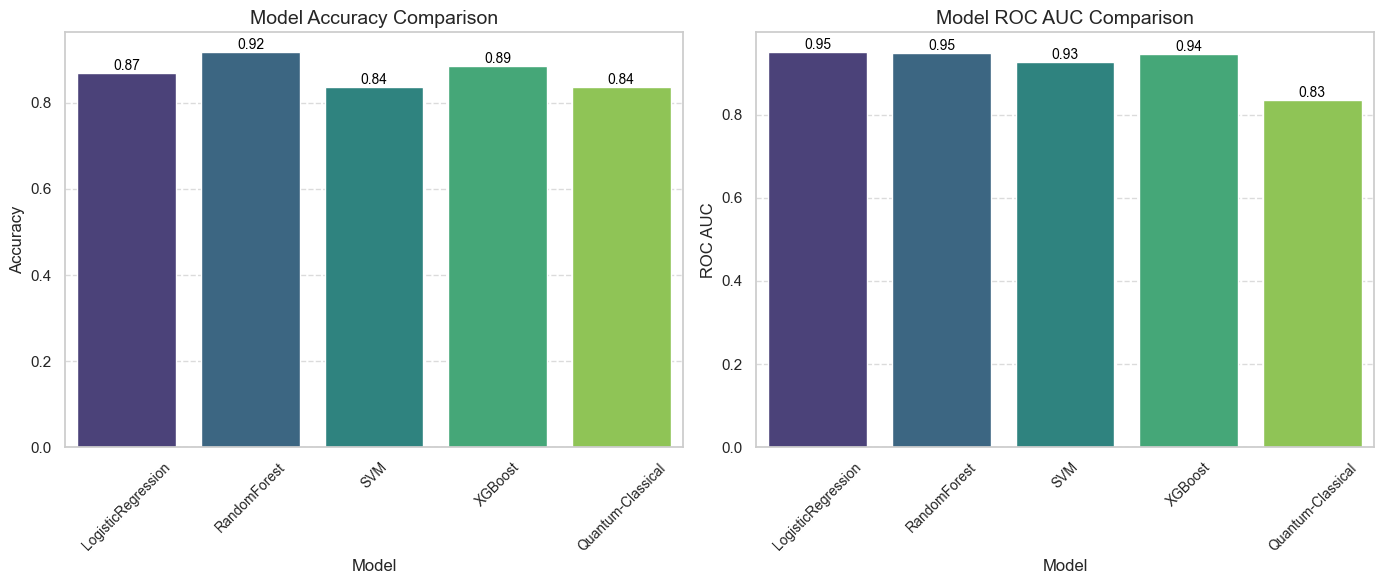

In [30]:
# Add QML model metrics to the results list
qml_results = {
    'model': 'Quantum-Classical',
    'accuracy': acc,
    'roc_auc': roc_auc_score(y_test_t.numpy(), preds.numpy())
}
results_list.append(qml_results)

# Convert results to a DataFrame for visualization
results_df = pd.DataFrame(results_list)

# Set Seaborn style
sns.set(style="whitegrid")

# Plot comparison of accuracy and ROC AUC
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
sns.barplot(data=results_df, x='model', y='accuracy', ax=axes[0], palette='viridis')
axes[0].set_title('Model Accuracy Comparison', fontsize=14)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
for p in axes[0].patches:
    axes[0].annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=10, color='black')

# ROC AUC comparison
sns.barplot(data=results_df, x='model', y='roc_auc', ax=axes[1], palette='viridis')
axes[1].set_title('Model ROC AUC Comparison', fontsize=14)
axes[1].set_ylabel('ROC AUC', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
for p in axes[1].patches:
    axes[1].annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# Conclusion

## 1 Model Performance Overview

Among the classical machine learning models, Random Forest and XGBoost achieved the highest accuracy and ROC AUC, indicating strong predictive performance on the heart disease dataset.

Logistic Regression performed slightly lower but still provided robust baseline results.

SVM showed slightly lower accuracy than ensemble methods but maintained a competitive ROC AUC, demonstrating good discrimination between classes.

## 2  Quantum-Classical Hybrid Model

The Quantum-Classical model achieved reasonable performance, but both accuracy and ROC AUC are lower than the best classical models.

This may be due to the dataset size (303 samples) may be too small to fully leverage quantum advantages.

## 3 Insights

Classical ensemble methods, especially Random Forest and XGBoost, remain highly effective for small tabular datasets like this one.

Quantum-classical hybrid models show potential but require larger datasets, more qubits, or deeper quantum circuits to outperform classical models.

The results demonstrate that quantum models are promising for research and experimentation, but for practical predictive tasks, classical models currently provide better performance and stability.

# ✅ Summary:
Classical models, particularly Random Forest and XGBoost, achieved the highest predictive performance, while the Quantum-Classical hybrid model performed decently but did not surpass classical methods. The project highlights both the current effectiveness of classical algorithms on tabular datasets and the potential of quantum-enhanced machine learning for future applications especially with larger and complex datasets.